# DCGANの実装
DCGANの解説スライド  
https://www.slideshare.net/HiroyaKato1/gandcgan-188544721?ref=https://blog.negativemind.com/2019/09/07/deep-convolutional-gan/   
元論文  
https://arxiv.org/pdf/1511.06434.pdf  
潜在変数の記事  
https://medium.com/hackernoon/latent-space-visualization-deep-learning-bits-2-bd09a46920df    
Kerasでの実装＋DCGANの解説  
https://qiita.com/taku-buntu/items/0093a68bfae0b0ff879d  



In [3]:
import random, math, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [4]:
input = torch.tensor([[[[1., 1.], [2., 2.]]]])
print("入力データ")
print(input)
print("-----")

print("通常の畳み込み")
m = nn.Conv2d(1, 1, 2, stride=1, bias=False)
m.weight[0, 0, 0, 0] = 1
m.weight[0, 0, 0, 1] = 2
m.weight[0, 0, 1, 0] = 3
m.weight[0, 0, 1, 1] = 4
print("カーネル")
print(m.weight)
print("出力")
print(m(input))

print("-----")
print("転置畳み込み")
m = nn.ConvTranspose2d(1, 1, 2, stride=1, bias=False)
m.weight[0, 0, 0, 0] = 1
m.weight[0, 0, 0, 1] = 2
m.weight[0, 0, 1, 0] = 3
m.weight[0, 0, 1, 1] = 4
print("カーネル")
print(m.weight)
print("出力")
print(m(input))

入力データ
tensor([[[[1., 1.],
          [2., 2.]]]])
-----
通常の畳み込み
カーネル
Parameter containing:
tensor([[[[1., 2.],
          [3., 4.]]]], grad_fn=<CopySlices>)
出力
tensor([[[[17.]]]], grad_fn=<MkldnnConvolutionBackward>)
-----
転置畳み込み
カーネル
Parameter containing:
tensor([[[[1., 2.],
          [3., 4.]]]], grad_fn=<CopySlices>)
出力
tensor([[[[ 1.,  3.,  2.],
          [ 5., 13.,  8.],
          [ 6., 14.,  8.]]]], grad_fn=<SlowConvTranspose2DBackward>)


# Generatorの実装

In [5]:
class Generator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size*8, kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size*8, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size*4, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size*2),
            nn.ReLU(inplace=True))
        
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size*2, image_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))
        
        # Generatorの出力の活性化関数をtanhとする
        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh())
        
    # 潜在変数zを入力とする
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

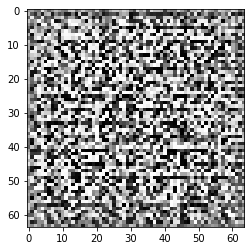

input: torch.Size([1, 20, 1, 1])
layer 1: torch.Size([1, 512, 4, 4])
layer 2: torch.Size([1, 256, 8, 8])
layer 3: torch.Size([1, 128, 16, 16])
layer 4: torch.Size([1, 64, 32, 32])
layer 5: torch.Size([1, 1, 64, 64])


In [6]:
# Generator 作成
G = Generator(z_dim=20, image_size=64)

# 入力潜在変数
input_z = torch.randn(1, 20)

# テンソルサイズを(1, 20, 1, 1)に変形
# (batchsize, channel, height, width)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

fake_images = G(input_z)

# (height, width)を取り出す
img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

print('input:',input_z.shape)

tensor = input_z
for i, layer in enumerate([G.layer1, G.layer2, G.layer3, G.layer4, G.last]):
    tensor = layer(tensor)
    print(('layer {}: {}').format(i+1, tensor.shape))

# Discriminatorの実装

In [7]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()
        
        # generatorからの出力はチャネルが１
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

In [8]:
D = Discriminator(z_dim=20, image_size=64)
G = Generator(z_dim=20, image_size=64)

input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0),input_z.size(1), 1, 1)
fake_images = G(input_z)

d_out = D(fake_images)

print(nn.Sigmoid()(d_out))

tensor([[[[0.5002]]]], grad_fn=<SigmoidBackward>)


# GANの損失関数

In [9]:
# Dの誤差関数のイメージ実装
# maximize log(D(x)) + log(1 - D(G(z)))

# 正解ラベルを作成
mini_batch_size = 2
label_real = torch.full((mini_batch_size,), 1)

# 偽ラベルを作成
label_fake = torch.full((mini_batch_size,), 0)

# 誤差関数を定義
criterion = nn.BCEWithLogitsLoss(reduce='mean')

# 真の画像を判定
d_out_real = D(x)

# 偽の画像を生成して判定
input_z = torch.randn(mini_batch_size, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
d_out_fake = D(fake_images)

# 誤差を計算
d_loss_real = criterion(d_out_real.view(-1), label_real)
d_loss_fake = criterion(d_out_fake.view(-1), label_fake)

d_loss = d_loss_real + d_loss_fake

/home/nagae/.conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


NameError: name 'x' is not defined

In [10]:
# Gの誤差関数のイメージ実装
# maximize log(D(G(z)))

# 偽の画像を生成して判定
input_z = torch.randn(mini_batch_size, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
d_out_fake = D(fake_images)

# 誤差を計算
g_loss = criterion(d_out_fake.view(-1), label_real)

# DataLoaderの作成

In [11]:
def make_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """
    
    train_img_list = list()
    
    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)
        
    return train_img_list

In [12]:
class ImageTransform():
    """画像の前処理クラス"""
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
            
    def __call__(self, img):
        return self.data_transform(img)

In [13]:
class GAN_img_Dataset(data.Dataset):
    
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        '''前処理をした画像のTensor形式のデータを取得'''
        
        img_path = self.file_list[index]
        img = Image.open(img_path) # [高さ][幅]白黒
        
        img_transformed = self.transform(img)
        
        return img_transformed            

torch.Size([64, 1, 64, 64])


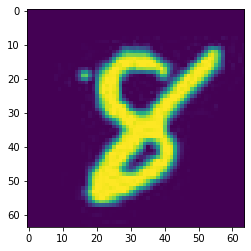

In [14]:
train_img_list = make_datapath_list()

mean = (0.5, )
std = (0.5, )
train_dataset = GAN_img_Dataset(file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoaderの作成
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

batch_iterator = iter(train_dataloader)
images = next(batch_iterator)
print(images.size())
plt.imshow(images[0][0])

# 学習検証

In [15]:
# ネットワークの初期化
def weight_init(m):
        classname = m.__class__.__name__ # pythonのクラスのデフォルト関数
        if classname.find('Conv') != -1:
            # Conv2dとConvTranspose2dの初期化
            # https://pytorch.org/docs/stable/nn.init.html
            # ガウス分布からの初期化
            nn.init.normal_(m.weight.data, 0.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
            
        elif classname.find('BatchNorm') != -1:
            # BatchNorm2dの初期化
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
        
G.apply(weight_init)
D.apply(weight_init)

print("ネットワークの初期化完了")

ネットワークの初期化完了


In [16]:
def train_model(G, D, dataloader, num_epochs):
    
    # GPUが使えるかを確認
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('device:', device)
    
    # 最適化手法の設定
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    
    g_optimizer = optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = optim.Adam(D.parameters(), d_lr, [beta1, beta2])
    
    # 誤差関数を定義
    criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    # パラメータをハードコーディング
    z_dim = 20
    mini_batch_size = 64
     
    G.to(device) # ネットワークをGPUへ
    D.to(device)
    
    G.train() # モデルを訓練モードに
    D.train()
    
    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True
    
    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    
    # イテレーションカウンタをセット
    iteration = 1
    logs = []
    
    for epoch in range(num_epochs):
        
        t_epoch_start = time.time()
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0
        
        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')
        
        for images in dataloader:
            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            
            # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
            if images.size()[0] == 1:
                continue
                
             # GPUが使えるならGPUにデータを送る
            images = images.to(device)
            
            # 正解ラベルと偽ラベルを作成
            # epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size = images.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)
            
            # 真の画像を判定
            d_out_real = D(images)
            
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)
            
            # 誤差を計算
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real+ d_loss_fake
            
            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            
            d_loss.backward()
            d_optimizer.step()
    
            # --------------------
            # 2. Generatorの学習
            # --------------------
            
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)  #  既にdiscriminatorへ入力するように作っているのに助長じゃない？？
            fake_images = G(input_z)
            d_out_fake = D(fake_images)
            
            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)
            
            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            # --------------------
            # 3. 記録
            # --------------------
            
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1
            
        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()
        
        log_epoch = {'epoch' : epoch+1,
                     'g_loss' : epoch_g_loss/batch_size,
                     'd_loss' : epoch_d_loss/batch_size}
        logs.append(log_epoch)
        df = pd.DataFrame(logs) 
        df.to_csv('result/mnist_log_output.csv')  
    
    return G, D

In [17]:
# 学習・検証を実行する
# 6分ほどかかる
num_epochs = 200
G_update, D_update = train_model(
    G, D, dataloader=train_dataloader, num_epochs=num_epochs)


device: cuda:0
-------------
Epoch 0/200
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:0.0886 ||Epoch_G_Loss:0.1593
timer:  0.9161 sec.
-------------
Epoch 1/200
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:0.0448 ||Epoch_G_Loss:0.2661
timer:  0.3665 sec.
-------------
Epoch 2/200
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:0.0028 ||Epoch_G_Loss:0.4947
timer:  0.3552 sec.
-------------
Epoch 3/200
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:0.1551 ||Epoch_G_Loss:0.4040
timer:  0.3547 sec.
-------------
Epoch 4/200
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:0.0408 ||Epoch_G_Loss:0.2192
timer:  0.3581 sec.
-------------
Epoch 5/200
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:0.2702 ||Epoch_G_Loss:0.3710
timer:  0.3575 sec.
-------------
Epoch 6/200
-------------
（train）
-------------
epoch 6 || Epoch_D_Loss:0.0255 ||Epoch_G_Loss:0.2269
timer:  0.3574 sec.
-------------
Epoch 7/200
-------------


-------------
epoch 60 || Epoch_D_Loss:0.1328 ||Epoch_G_Loss:0.1299
timer:  0.3638 sec.
-------------
Epoch 61/200
-------------
（train）
-------------
epoch 61 || Epoch_D_Loss:0.1078 ||Epoch_G_Loss:0.1326
timer:  0.3637 sec.
-------------
Epoch 62/200
-------------
（train）
-------------
epoch 62 || Epoch_D_Loss:0.1086 ||Epoch_G_Loss:0.1383
timer:  0.3659 sec.
-------------
Epoch 63/200
-------------
（train）
-------------
epoch 63 || Epoch_D_Loss:0.1148 ||Epoch_G_Loss:0.1348
timer:  0.3648 sec.
-------------
Epoch 64/200
-------------
（train）
-------------
epoch 64 || Epoch_D_Loss:0.0987 ||Epoch_G_Loss:0.1487
timer:  0.3661 sec.
-------------
Epoch 65/200
-------------
（train）
-------------
epoch 65 || Epoch_D_Loss:0.1332 ||Epoch_G_Loss:0.1214
timer:  0.3644 sec.
-------------
Epoch 66/200
-------------
（train）
-------------
epoch 66 || Epoch_D_Loss:0.1077 ||Epoch_G_Loss:0.1442
timer:  0.3654 sec.
-------------
Epoch 67/200
-------------
（train）
-------------
epoch 67 || Epoch_D_Loss:0.

-------------
epoch 120 || Epoch_D_Loss:0.0849 ||Epoch_G_Loss:0.2198
timer:  0.3626 sec.
-------------
Epoch 121/200
-------------
（train）
-------------
epoch 121 || Epoch_D_Loss:0.0902 ||Epoch_G_Loss:0.2486
timer:  0.3691 sec.
-------------
Epoch 122/200
-------------
（train）
-------------
epoch 122 || Epoch_D_Loss:0.0601 ||Epoch_G_Loss:0.2144
timer:  0.3628 sec.
-------------
Epoch 123/200
-------------
（train）
-------------
epoch 123 || Epoch_D_Loss:0.0797 ||Epoch_G_Loss:0.2323
timer:  0.3632 sec.
-------------
Epoch 124/200
-------------
（train）
-------------
epoch 124 || Epoch_D_Loss:0.0795 ||Epoch_G_Loss:0.2204
timer:  0.3625 sec.
-------------
Epoch 125/200
-------------
（train）
-------------
epoch 125 || Epoch_D_Loss:0.0526 ||Epoch_G_Loss:0.2431
timer:  0.3635 sec.
-------------
Epoch 126/200
-------------
（train）
-------------
epoch 126 || Epoch_D_Loss:0.0933 ||Epoch_G_Loss:0.2008
timer:  0.3688 sec.
-------------
Epoch 127/200
-------------
（train）
-------------
epoch 127 || 

-------------
epoch 179 || Epoch_D_Loss:0.0529 ||Epoch_G_Loss:0.2832
timer:  0.3712 sec.
-------------
Epoch 180/200
-------------
（train）
-------------
epoch 180 || Epoch_D_Loss:0.0448 ||Epoch_G_Loss:0.3677
timer:  0.3679 sec.
-------------
Epoch 181/200
-------------
（train）
-------------
epoch 181 || Epoch_D_Loss:0.0461 ||Epoch_G_Loss:0.3288
timer:  0.3692 sec.
-------------
Epoch 182/200
-------------
（train）
-------------
epoch 182 || Epoch_D_Loss:0.0389 ||Epoch_G_Loss:0.3225
timer:  0.3687 sec.
-------------
Epoch 183/200
-------------
（train）
-------------
epoch 183 || Epoch_D_Loss:0.0549 ||Epoch_G_Loss:0.3460
timer:  0.3702 sec.
-------------
Epoch 184/200
-------------
（train）
-------------
epoch 184 || Epoch_D_Loss:0.0296 ||Epoch_G_Loss:0.3563
timer:  0.3695 sec.
-------------
Epoch 185/200
-------------
（train）
-------------
epoch 185 || Epoch_D_Loss:0.0627 ||Epoch_G_Loss:0.2991
timer:  0.3701 sec.
-------------
Epoch 186/200
-------------
（train）
-------------
epoch 186 || 

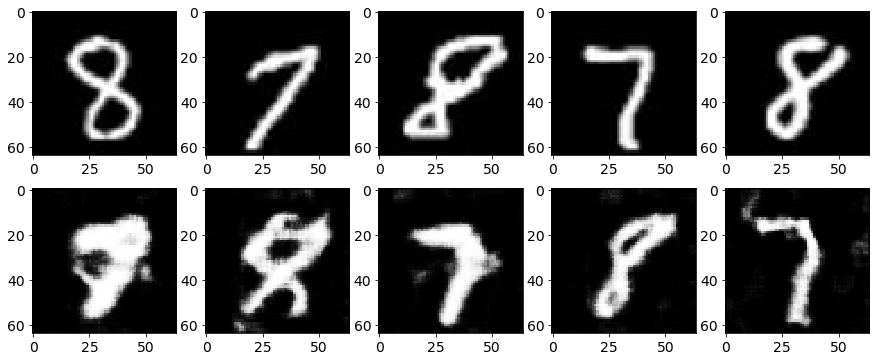

In [22]:
# 生成画像と訓練データを可視化する
# 本セルは良い感じの画像が生成されるまで、何度も実行し直しています。

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 画像生成
fake_images = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す


# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

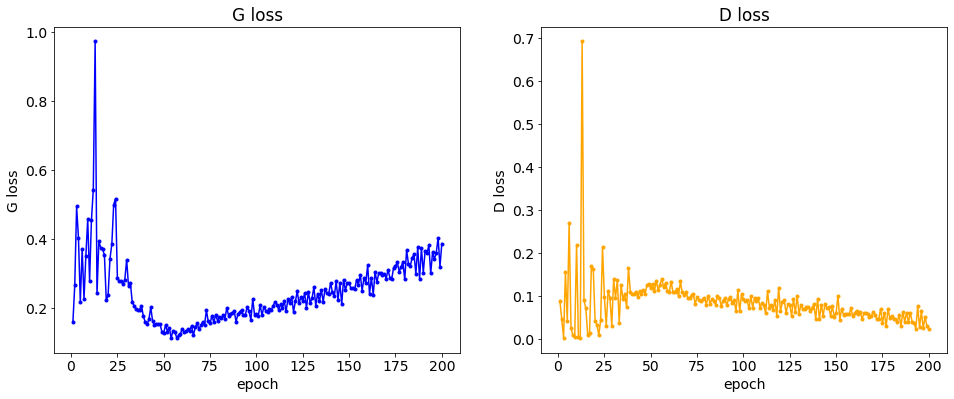

In [20]:
def plot_lr(df):
    plt.rcParams['font.size'] = 14
    fig = plt.figure(figsize=(16, 6))
    ax = fig.add_subplot(121)
    ax.plot(df['epoch'], df['g_loss'], '.-', c='b',label='G')
    ax.set_xlabel('epoch', fontsize=14)
    ax.set_ylabel('G loss', fontsize=14)
    ax.set_title('G loss')

    ax = fig.add_subplot(122)
    ax.plot(df['epoch'], df['d_loss'], '.-', c='orange',label='D')
    ax.set_xlabel('epoch', fontsize=14)
    ax.set_ylabel('D loss', fontsize=14)
    ax.set_title('D loss')

    fig.savefig('result/learnig_curbe.png')

df = pd.read_csv('result/mnist_log_output.csv')
plot_lr(df)

In [95]:
steps = 10


start_input = torch.randn(batch_size, z_dim).view(batch_size, 20, 1, 1).to(device)

end_input =  torch.randn(batch_size, z_dim).view(batch_size, 20, 1, 1).to(device)

start_img = G_update(start_input)[1]
end_img = G_update(end_input)[4]

vectors = []

alpha_values = np.linspace(0, 1, steps)
for alpha in alpha_values:
    vector = start_input * (1 - alpha) + end_input * alpha
    vectors.append(vector)

vectors = np.array(vectors)

imgs = []
for i, vec in enumerate(vectors):
    gen_img = G_update(vec)
    imgs.append(gen_img)

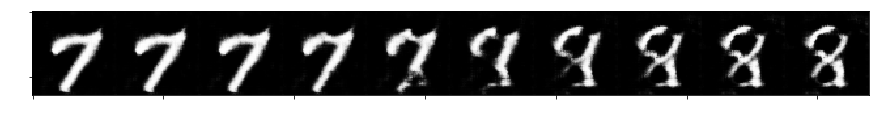

In [96]:
import cv2
concat_imgs = []
for i in range(len(imgs)):
    concat_imgs.append(imgs[i][0][0].cpu().detach().numpy())
    
fig = plt.figure(figsize=(15,5))
plt.imshow(cv2.hconcat(concat_imgs), 'gray')
plt.xticks(color="None")
plt.yticks(color="None")
plt.show()